In [107]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [108]:
fetch_housing_data()

URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>

In [253]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [254]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [255]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [256]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [257]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


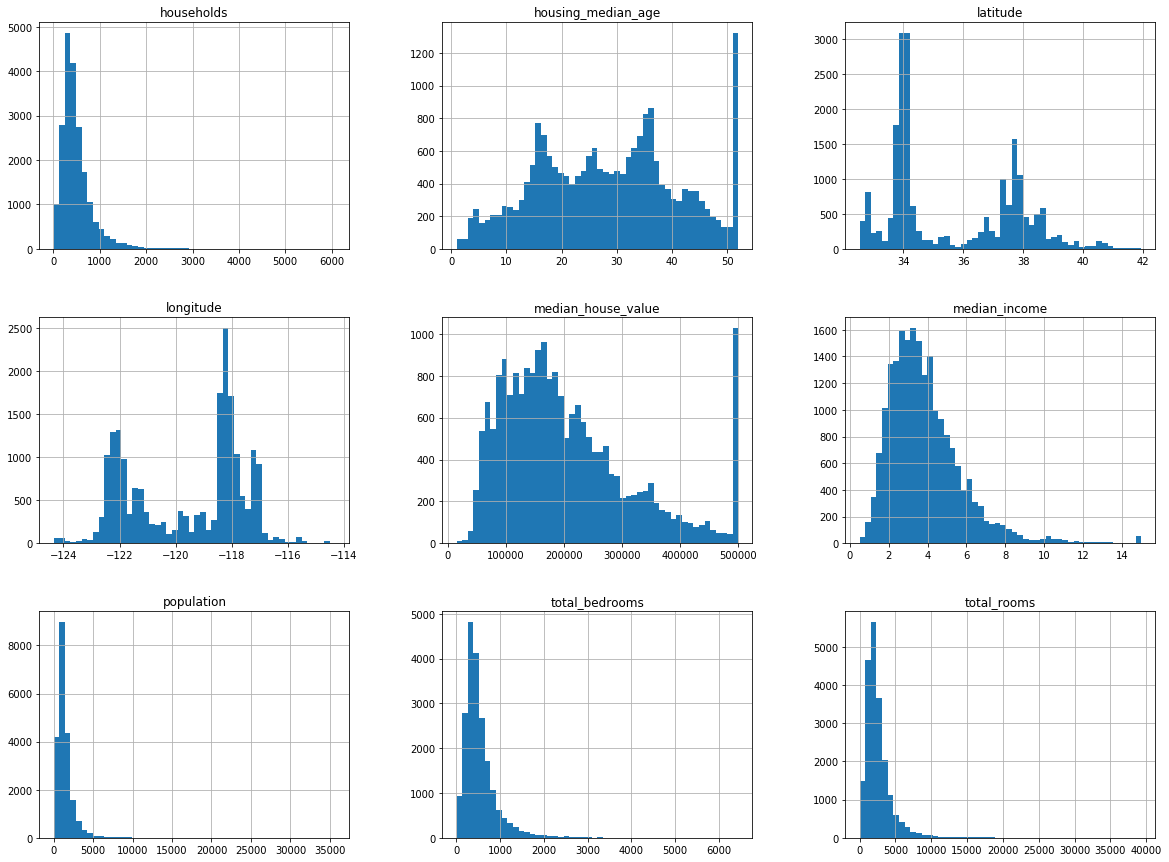

In [258]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

接下来要创建测试集，简单方法是随机选择数据集的20%作为测试集。  
   $   $cons: 如果运行多次，会产生不一样的训练集，这样导致机器学习算法会看到完整的数据集。  <br><br>
改进：第一次运行程序后保存测试集，随后运行都只是加载它。 或者 设置一个随机数生成器seed。  
   cons: 这两种方法在下一次获取更新的数据时都会中断。

In [259]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indeices = np.random.permutation(len(data))            # 打乱数据集index顺序
    test_set_size = int(len(data)*test_ratio)                       # 计算测试集大小
    test_indices = shuffled_indeices[:test_set_size]                # 把shuffled_indices前test_set_size个作为测试集
    train_indices = shuffled_indeices[test_set_size: ]              # 剩下的index作为是训练集
    return data.iloc[train_indices], data.iloc[test_indices]
# train_set, test_set = split_train_test(housing, 0.2)

另一种办法来改进缺点：给每个例子使用一个**唯一标识符**来决定是否进入测试集。比如，标识符用hash值，取hash值最后一个字节，如果该值小于等于51（约256的20%），  则将该例子放入测试集。


In [260]:
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]<256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [261]:
housing_with_id = housing.reset_index()              # 加入索引列
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')              #使用索引列作为唯一标识符

以上是村随机抽样的方法，但纯随机抽样很可能会采样偏斜。   
改进：使用**分层抽样**。根据*收入中位数*进行分层抽样。

In [262]:
housing["income_cat"] = np.ceil(housing['median_income']/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)     #将median_income分为5层。

In [263]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)         # 分层抽样，每一层拿出20%作为测试集。random seed设为42。只要1对train/test set。
for train_index, test_index in split.split(housing, housing["income_cat"]):        # 按照income_cat属性对housing做分层抽样
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [264]:
#验证
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [265]:
# 删除income_cat属性
for pair in (strat_train_set, strat_test_set):
    pair.drop(["income_cat"], axis=1, inplace=True)

In [266]:
strat_train_set.inｆｏ()      #观察income_cat被删掉没有

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


# 从数据探索和可视化中洞见

In [267]:
housing = strat_train_set.copy()    #创建一个训练集副本，可以随便尝试且不顺坏训练集

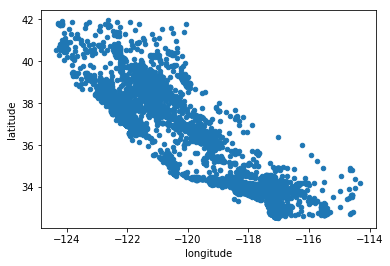

In [268]:
# 将经纬度可视化
housing.plot(kind="scatter", x="longitude", y="latitude")

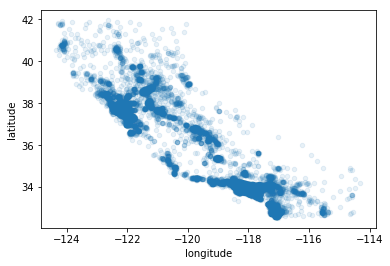

In [269]:
# alpha设成0.1，让高密度数据区更清晰
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

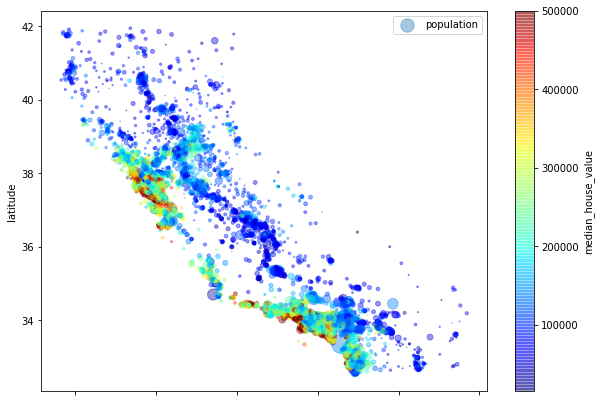

In [270]:
housing.plot(figsize=(10, 7), kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", c="median_house_value", colormap=plt.get_cmap("jet"), colorbar=True)
# c:size of each pt        c:color of each pt      
plt.legend()

In [271]:
corr_matrix = housing.corr()      # 任意两个属性的correlation
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


# 寻找相关性

In [272]:
# 观察每个属性与房价中位数（我们希望预测的）的correlation
corr_matrix["median_house_value"].sort_values(ascending=True)

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

C:\Users\peter\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6B6319B00>,
      dtype=object)

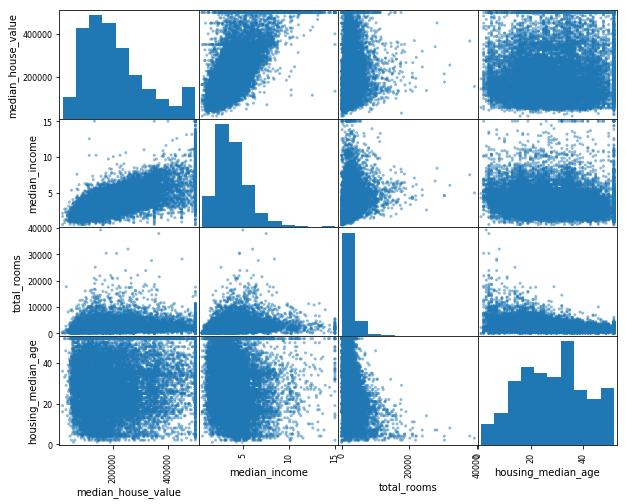

In [273]:
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(10, 8))

# 试验不同属性的组合

In [274]:
#在给机器学习算法输入数据前，可以尝试各种属性的组合，可能会得到与目标属性房价中位数更相关的属性。
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [275]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

结果发现bedrooms_per_room与房价中位数相关性挺高的。

# 机器学习算法的数据准备

In [276]:
# 获取训练集和标签
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

处理missing features  
这里total_bedrooms属性有部分missing value，有三种解决办法：  
1. 放弃这些missing value相应的区域
2. 放弃total_bedrooms这个属性
3. 给missing value赋值（0， 平均数， 中位数）

`dropna()`,`drop()`,`fillna()`可完成上述操作。

In [277]:
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)     # option 3
print()

scikit-learn提供了一个处理缺失值的手段  ----- `Imputer`

In [278]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

In [279]:
# 创建一个没有文本属性的dataframe
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [280]:
#imputer计算了每个属性的median, 并将结果存储在statistics_中。
imputer.statistics_ == housing_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [281]:
X = imputer.transform(housing_num)   # 将housing_num中的缺失值替换成中位数
housing_tr = pd.DataFrame(X, columns=housing_num.columns)  # X是numpy数组，变回成DataFrame

fit和transform可以直接fit_transform  
```
imputer.fit_transform(housing_num)
```

所有估算器的超参数都可以通过公共实例变量直接访问，比如`imputer.strategy`  
所有估算器的学习参数也可以通过有下划线后缀的公共实例变量访问， 比如`imputer.strategy_`

# 处理文本和分类属性

之前排除了分类属性ocean_proximity。我们无法计算文本属性的中位数。 所以我们把这些文本标签转化为数字。  
scikt-learn为这类任务提供了个转换器 LabelEncoder。

In [282]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [283]:
# 用classes_来查看编码器的映射
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

缺点：机器学习算法会以为两个相近的数字比离得远的数字更为相似一些。  
<br>
另一种编码方式：one-hot encoding

In [284]:
# scikit-learn提供了OneHotEncoder编码器。
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

C:\Users\peter\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

此时的housing_cat_1hot是一个scipy稀疏矩阵，而不是一个NumPy数组。

In [285]:
#可以用一下toarray()方法把稀疏矩阵变成密集NumPy数组。
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [286]:
#使用LabelBinarizer类可以一次性完成两个转换（文本->整数类别 ，  整数类别->独热向量）
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [287]:
# 得到稀疏矩阵
encoder = LabelBinarizer(sparse_output = True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

# 自定义转换器

In [288]:
from sklearn.base import BaseEstimator, TransformerMixin
room_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, room_ix]/X[:, household_ix]
        population_per_household = X[:, population_ix]/X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [291]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

# 特征放缩

两种同比放缩所有属性：
1. 最小-最大放缩：减去最小值，除以最大值与最小值的差。
 - 将值绑定到特定范围
2. 标准化：减去平均数，除以方差。
 - 受异常值影响更少
 - scikit-learn提供了一个标准化转化器**StandadScaler**。

# 转换流水线

In [345]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

Pipeline构造函数通过一系列 **名称/估算器** 来定义步骤的序列。  
除了最后一个是估算器外，前面的必须都是转换器（也就是说，必须有fit_transform()方法）。  
当调用流水线fit()时，会在所有转换器上按顺序调用fit_transform()，前一个的输出作为参数传递给下一个作为输入，知道传递到最终的估算器，则只调用估算器的fit()方法。  
差不多可以这样理解（语法不对）：`num_pipeline.fit() = StandardScaler.fit(CombinedAttributesAdder.fit_transform(Imputer.fit_transform()))`

num_pipeline是一个处理数值的流水线。我们还需要在分类值上应用LabelBinarizer.  
scikit-learn提供了**FeatureUnion类**。 当它的transform（）（or fit()）被调用时，它会并行运行每个转换器的transform（）(or fit())方法。

In [346]:
from sklearn.base import BaseEstimator, TransformerMixin
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [347]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [348]:
# scikit-learn提供了ColumnTransformer，可以更简单实现以上步骤,不需要自定义DataFrameSelector
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# 选择和训练模型

### 培训和评估训练集

In [349]:
# 训练一个线性模型
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [304]:
# 用几个训练及实例试试
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))      # 模型预测的值

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [308]:
print("Labels:\t", list(some_labels))                             # 真实的label

Labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [309]:
# 用mean_squared_error函数来测量训练集上线性回归模型的RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

线性回归效果比较差，这是一个典型的underfit的情况。  
换一个模型，用决策树回归尝试一下。

In [311]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [312]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

决策树回归的rmse是0. 有可能是过拟合（overfit）了，如何确认是不是过拟合？

### 用交叉验证来评估

scikit-learn提供了**交叉验证功能**。  
**K-fold 交叉验证**： 将训练集分割成10个不同的子集，每个子集成为一个flod，然后对决策树模型进行10次训练和评估-----每次用9个flod训练，用1个fold评估。

In [317]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores

array([69599.30710455, 67212.47012002, 70281.87325745, 69730.08745315,
       71173.6110561 , 75236.21454436, 72184.44999024, 71089.68311469,
       75402.28609556, 69699.14594985])

In [322]:
# 看看结果如何
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_scores(rmse_scores)

Scores:  [69599.30710455 67212.47012002 70281.87325745 69730.08745315
 71173.6110561  75236.21454436 72184.44999024 71089.68311469
 75402.28609556 69699.14594985]
Mean:  71160.9128685983
Standard deviation:  2421.4817982666555


In [327]:
# 看一下线性回归在10-flod交叉验证中的表现
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.6740017983493


In [328]:
# 尝试一下随机森林回归
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [329]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean:  52583.72407377466
Standard deviation:  2298.353351147122


随机森林看起来效果最好

note: 每一个尝试过的模型都要妥善保管，这样以后可以轻松回到。同时还要保留超参数和训练过的参数，和交叉验证的评估和实际预测的结果。  
Python的pickel模块或者是sklearn.externals.joblib，可以轻松保存scikit-learn模型。

In [331]:
from sklearn.externals import joblib
joblib.dump(lin_reg, "lin_reg.pkl")
my_model_loaded = joblib.load("lin_reg.pkl")

# 微调模型

当有了一个有效模型的候选列表，如何对他们进行微调？

### 网格搜索

scikit-learn的GridSearchCV来调整超参数。我们需要告诉它要进行实验的超参数是什么，以及需要尝试的值，它会用交叉验证来评估超参数的所有可能的组合。

In [334]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [335]:
# 得到的最好估算器
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [337]:
# 每个情况的评估分数
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64245.82100198822 {'max_features': 2, 'n_estimators': 3}
55826.47341838651 {'max_features': 2, 'n_estimators': 10}
53052.59696070161 {'max_features': 2, 'n_estimators': 30}
59591.460669396554 {'max_features': 4, 'n_estimators': 3}
53428.957011975435 {'max_features': 4, 'n_estimators': 10}
50778.37842011717 {'max_features': 4, 'n_estimators': 30}
60007.065264622484 {'max_features': 6, 'n_estimators': 3}
52528.55148565492 {'max_features': 6, 'n_estimators': 10}
50002.96805226455 {'max_features': 6, 'n_estimators': 30}
59317.62757405218 {'max_features': 8, 'n_estimators': 3}
52306.14885117071 {'max_features': 8, 'n_estimators': 10}
49902.41859679617 {'max_features': 8, 'n_estimators': 30}
63524.447902810396 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54473.25009212952 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59117.8082600266 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52766.6578068214 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

### 随即搜索

如果搜索的组合数量较少，网格搜索是一个不错的办法。但是当超参数的搜索范围太大，会话很长时间，效率很低。  
这种情况下更好的选择是**RandomizedSearchCV**。  
它不会尝试所有可能的组合，而是在每次迭代中为每个超参数选择一个随机值，然后对一定数量的随机超参数组合进行评估。
特性：
- 随机搜索1000次，那么每个超参数会被搜索到1000个不同的值。
- 通过简单的设置迭代次数，可以控制要分配给探索的超参数的计算预算。

# 通过测试机评估系统

In [350]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)           # 这里是transform()而不是fit_transform()  因为这是测试集，不能通过测试集改变模型参数
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48239.048766712265